In [2]:
#importando as bibliotecas
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Lendo csv

df = pd.read_csv('https://raw.githubusercontent.com/carlosgiongo/Apple-Act./main/full_apple.csv')
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [4]:
#Convertendo data do object para date
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-28,1.022321,1.053571,1.018973,1.036830,0.890239,359004800
1,2000-08-29,1.033482,1.061384,1.030134,1.056920,0.907489,267030400
2,2000-08-30,1.053571,1.071429,1.048270,1.062500,0.912280,285392800
3,2000-08-31,1.053013,1.098214,1.052455,1.088170,0.934321,419596800
4,2000-09-01,1.094866,1.136161,1.091518,1.132813,0.972652,256872000


In [5]:
#Criando tabelas de média de dias
df['mm5d'] = df['Close'].rolling(5).mean()
df['mm21d'] = df['Close'].rolling(21).mean()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,mm5d,mm21d
0,2000-08-28,1.022321,1.053571,1.018973,1.036830,0.890239,359004800,NaN,NaN
1,2000-08-29,1.033482,1.061384,1.030134,1.056920,0.907489,267030400,NaN,NaN
2,2000-08-30,1.053571,1.071429,1.048270,1.062500,0.912280,285392800,NaN,NaN
3,2000-08-31,1.053013,1.098214,1.052455,1.088170,0.934321,419596800,NaN,NaN
4,2000-09-01,1.094866,1.136161,1.091518,1.132813,0.972652,256872000,1.075447,NaN


In [22]:
df['Close'] = df['Close'].shift(-1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,mm5d,mm21d
0,2000-09-26,0.952009,0.977679,0.917411,0.955357,0.788662,290936800,0.981641,1.041335
1,2000-09-27,0.924107,0.941964,0.861607,0.459821,0.750331,402259200,0.938393,1.033575
2,2000-09-28,0.880580,0.960938,0.859375,0.433036,0.820285,979585600,0.927009,1.028739
3,2000-09-29,0.503348,0.517857,0.453125,0.398438,0.394810,7421640800,0.832589,1.000040
4,2000-10-02,0.476563,0.477679,0.419643,0.421875,0.371812,2424788800,0.728125,0.968843


In [7]:
#Dropando dados nulos 
df.dropna(inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume,mm5d,mm21d
20,2000-09-26,0.952009,0.977679,0.917411,0.873884,0.788662,290936800,0.981641,1.041335
21,2000-09-27,0.924107,0.941964,0.861607,0.955357,0.750331,402259200,0.938393,1.033575
22,2000-09-28,0.880580,0.960938,0.859375,0.459821,0.820285,979585600,0.927009,1.028739
23,2000-09-29,0.503348,0.517857,0.453125,0.433036,0.394810,7421640800,0.832589,1.000040
24,2000-10-02,0.476563,0.477679,0.419643,0.398438,0.371812,2424788800,0.728125,0.968843
...,...,...,...,...,...,...,...,...,...
5278,2021-08-20,147.440002,148.500000,146.779999,149.710007,148.190002,59947400,148.511999,147.234762
5279,2021-08-23,148.309998,150.190002,147.889999,149.619995,149.710007,60131800,148.230002,147.289525
5280,2021-08-24,149.449997,150.860001,149.149994,148.360001,149.619995,48606400,148.116000,147.319524
5281,2021-08-25,149.809998,150.320007,147.800003,147.539993,148.360001,58991300,148.516000,147.395238


In [8]:
#verificando quantidade de linhas
qtd_linhas = len(df)

#Setando linhas para treino
qtd_linhas_treino= round(.70 * qtd_linhas)

#Setando linhas para teste
qtd_linhas_teste= qtd_linhas - qtd_linhas_treino  

#Setando linhas de validação
qtd_linhas_validacao = qtd_linhas -1

info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f" linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste -1}"
    f" linhas validação= {qtd_linhas_validacao}"
)

info

'linhas treino= 0:3684 linhas teste= 3684:5262 linhas validação= 5262'

In [9]:
#Resetando index dos id's
df = df.reset_index(drop=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume,mm5d,mm21d
0,2000-09-26,0.952009,0.977679,0.917411,0.873884,0.788662,290936800,0.981641,1.041335
1,2000-09-27,0.924107,0.941964,0.861607,0.955357,0.750331,402259200,0.938393,1.033575
2,2000-09-28,0.880580,0.960938,0.859375,0.459821,0.820285,979585600,0.927009,1.028739
3,2000-09-29,0.503348,0.517857,0.453125,0.433036,0.394810,7421640800,0.832589,1.000040
4,2000-10-02,0.476563,0.477679,0.419643,0.398438,0.371812,2424788800,0.728125,0.968843
...,...,...,...,...,...,...,...,...,...
5258,2021-08-20,147.440002,148.500000,146.779999,149.710007,148.190002,59947400,148.511999,147.234762
5259,2021-08-23,148.309998,150.190002,147.889999,149.619995,149.710007,60131800,148.230002,147.289525
5260,2021-08-24,149.449997,150.860001,149.149994,148.360001,149.619995,48606400,148.116000,147.319524
5261,2021-08-25,149.809998,150.320007,147.800003,147.539993,148.360001,58991300,148.516000,147.395238


In [10]:
#separando as features e labels
features = df.drop(['Close', 'Date'], 1)
labels = df['Close']

In [11]:
#Features para checar se são boas para uso
features_list = ('Open','High','Low', 'Adj Close', 'Volume', 'mm5d','mm21d')

#Etapas para checar melhores features para treino dps
k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)


Melhores features:
{'Low': 7053.06215177217, 'Adj Close': 7011.626383402318, 'High': 6270.722546425267, 'Volume': 6229.604923968277, 'mm21d': 5716.691826849431, 'mm5d': 1.3788240438909969}


In [12]:
#separando as features escolhidas (melhor desempenho)
features = df.loc[:,['Low','Adj Close','High','Volume', 'mm21d']]

In [13]:
features

,Low,Adj Close,High,Volume,mm21d
0,0.917411,0.788662,0.977679,290936800,1.041335
1,0.861607,0.750331,0.941964,402259200,1.033575
2,0.859375,0.820285,0.960938,979585600,1.028739
3,0.453125,0.394810,0.517857,7421640800,1.000040
4,0.419643,0.371812,0.477679,2424788800,0.968843
...,...,...,...,...,...
5258,146.779999,148.190002,148.500000,59947400,147.234762
5259,147.889999,149.710007,150.190002,60131800,147.289525
5260,149.149994,149.619995,150.860001,48606400,147.319524
5261,147.800003,148.360001,150.320007,58991300,147.395238


In [14]:
#Separa os dados de treino teste e validação
X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

3684 3684
1578 1578


In [15]:
# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

In [16]:
#Treino
lr = linear_model.LinearRegression()
lr.fit(X_train_scale, y_train)
pred= lr.predict(X_test_scale)
cd =r2_score(y_test, pred)

f'Coeficiente de determinação:{cd * 100:.2f}'

'Coeficiente de determinação:99.80'

In [27]:
#Define quais ultimas linhas eu quero usar para de fato prever agora com o modelo treinado
last = 20;
valor_novo = features.tail(last)

In [28]:
#executando a previsão
previsao=scaler.transform(valor_novo)
pred=lr.predict(previsao)

In [29]:
#Importo um CSV sem ligação com o primeiro df, para checar efetivação
df2 = pd.read_csv('https://raw.githubusercontent.com/carlosgiongo/Apple-Act./main/full_apple.csv')

data_pregao_full=df2['Date']
data_pregao=data_pregao_full.tail(last)

res_full=df2['Close']
res=res_full.tail(last)

df2=pd.DataFrame({'Date':data_pregao, 'real':res, 'previsao':pred})
df2.set_index('Date', inplace=True)

print(df2)

                  real    previsao
Date                              
2021-08-02  145.520004  147.339853
2021-08-03  147.360001  148.089953
2021-08-04  146.949997  148.775322
2021-08-05  147.059998  149.102964
2021-08-06  146.139999  149.087570
2021-08-09  146.089996  148.422522
2021-08-10  145.600006  148.178226
2021-08-11  145.860001  148.481519
2021-08-12  148.889999  148.162901
2021-08-13  149.100006  149.738804
2021-08-16  151.119995  151.037730
2021-08-17  150.190002  151.270406
2021-08-18  146.360001  152.556667
2021-08-19  146.699997  150.325731
2021-08-20  148.190002  148.376399
2021-08-23  149.710007  149.812933
2021-08-24  149.619995  151.271318
2021-08-25  148.360001  152.134606
2021-08-26  147.539993  151.124418
2021-08-27  148.600006  150.342204


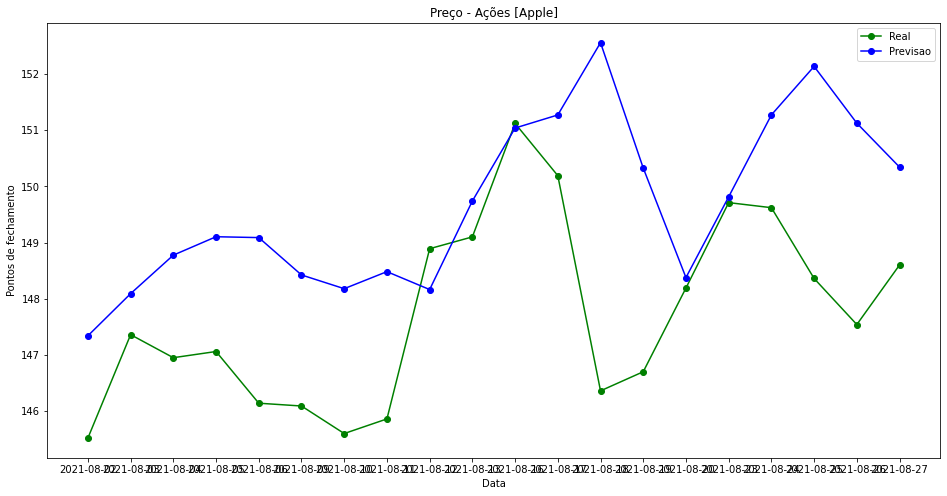

In [30]:
# GRAFICO

plt.figure(figsize=(16 ,8))
plt.title('Preço - Ações [Apple]')
plt.plot(df2['real'],label="Real",color="green", marker='o')
plt.plot(df2['previsao'],label="Previsao",color="blue", marker='o')
plt.xlabel('Data')
plt.ylabel('Pontos de fechamento')
leg = plt.legend()